https://github.com/vslobody/MUSIC/blob/master/music.py
https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT

In [7]:
import numpy as np
from scipy.constants import speed_of_light
import matplotlib.pyplot as plt

In [8]:
INCIDENT_ANGLE = 60  # incident signal angle in degrees
ANTENNA_DISTANCE = 6e-2  # distance between antennas in m
FREQUENCY_DEVIATION = 250e3
NUM_ANTENNAS = 4
BLUETOOTH_FREQUENCY = 2450e6  # Center frequency of Bluetooth channel in Hz
CTE_FREQUENCY = BLUETOOTH_FREQUENCY + FREQUENCY_DEVIATION
CTE_WAVELENGTH = speed_of_light / BLUETOOTH_FREQUENCY  # Bluetooth wavelength in m
CTE_TIME = 160e-6
NUM_SOURCES = 1

/usr/src/ENEL300-Bluetooth-Direction-Finding/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


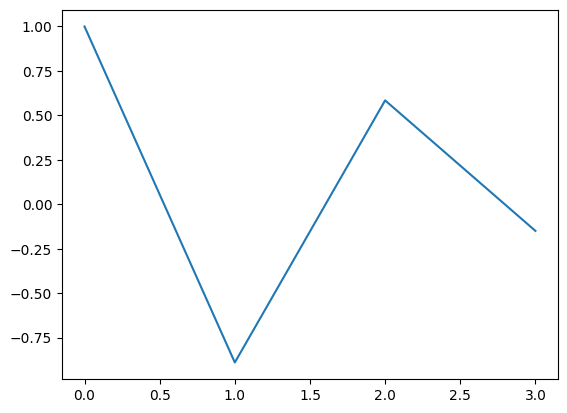

In [9]:
def steering_vec(num_antennas: int, incident_angle: float) -> np.ndarray:
    antennas = np.arange(0, num_antennas) * ANTENNA_DISTANCE
    steering = np.exp(
        2j
        * np.pi
        * antennas
        * np.sin(np.deg2rad(incident_angle))
        / CTE_WAVELENGTH
    ).reshape((-1, 1))
    return steering

steering = steering_vec(NUM_ANTENNAS, INCIDENT_ANGLE)
plt.plot(steering)

In [10]:
CTE_SAMPLES = 50

def iq_sample(time: float) -> np.ndarray:
    """Generate an IQ sample for a given time"""

    return np.sin(2 * np.pi * CTE_FREQUENCY * time) * steering


sample_times = np.linspace(0, CTE_TIME, CTE_SAMPLES)
sample_covariance = np.zeros(shape=(NUM_ANTENNAS, NUM_ANTENNAS), dtype=complex)
for t in sample_times:
    iq_sample_at_t = iq_sample(t)
    sample_covariance += iq_sample_at_t @ iq_sample_at_t.conjugate().T
sample_covariance /= CTE_SAMPLES

_, cov_eigvecs = np.linalg.eig(sample_covariance)
non_noise_cov_eigvecs = cov_eigvecs[:,NUM_SOURCES:NUM_ANTENNAS]
np.save("cov.npy", sample_covariance)

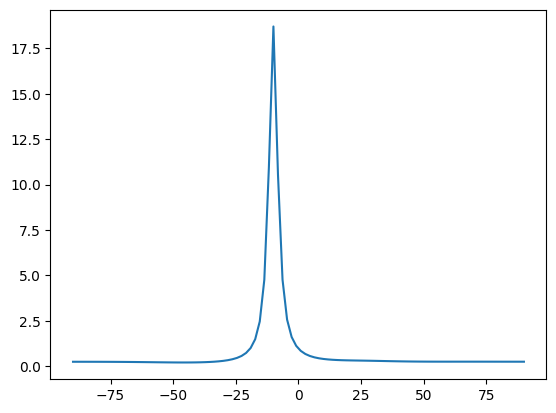

In [11]:
NUM_ANGLES_TO_TEST = 100

# non_noise_cov_eig_idx = cov_eigvals.argsort()[NUM_SOURCES:NUM_ANTENNAS]
# non_noise_cov_eigvecs = cov_eigvecs[:, non_noise_cov_eig_idx]

signal_power = np.ndarray(shape=(NUM_ANGLES_TO_TEST,), dtype=complex)
angles_to_test = np.linspace(-90, 90, NUM_ANGLES_TO_TEST)

for idx, angle in enumerate(angles_to_test):
    steering_at_test_angle = steering_vec(NUM_ANTENNAS, angle)
    signal_power[idx] = (
        1
        / (
            steering_at_test_angle.conjugate().T
            @ non_noise_cov_eigvecs
            @ non_noise_cov_eigvecs.conjugate().T
            @ steering_at_test_angle
        )
    ).item()


signal_power
fig, ax = plt.subplots()
ax.plot(angles_to_test, signal_power);
